In [2]:
# !pip install tensorflow
# !pip install matplotlib
# !pip install numpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [4]:
# Загрузка данных Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [5]:
# Нормализация данных в диапазон [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0


In [6]:
# Добавление размерности канала (изображения grayscale)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [7]:
# Параметры модели
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 30
noise_dim = 100  # Размерность шумового вектора
num_examples_to_generate = 16  # Количество примеров для генерации

In [8]:
# Создание Dataset для обучения
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
# Создание генератора
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [10]:
# Создание дискриминатора
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    return model

In [11]:
# Инициализация моделей
generator = make_generator_model()
discriminator = make_discriminator_model()

# Функции потерь
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Оптимизаторы
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(5e-5)

C:\Users\Computer\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Computer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Подготовка для визуализации прогресса
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Функция для генерации и сохранения изображений
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [13]:
# Декоратор для ускорения вычислений
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [14]:
# Функция обучения
def train(dataset, epochs):
    history = []
    
    for epoch in range(epochs):
        gen_loss_epoch = 0
        disc_loss_epoch = 0
        num_batches = 0
        
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += gen_loss
            disc_loss_epoch += disc_loss
            num_batches += 1
        
        gen_loss_epoch /= num_batches
        disc_loss_epoch /= num_batches
        
        history.append((gen_loss_epoch, disc_loss_epoch))
        
        # Генерация изображений каждые 10 эпох
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)
        
        print(f'Epoch {epoch + 1}/{epochs}, Gen Loss: {gen_loss_epoch:.4f}, Disc Loss: {disc_loss_epoch:.4f}')
    
    return history

Epoch 1/30, Gen Loss: 0.8083, Disc Loss: 1.3089
Epoch 2/30, Gen Loss: 0.9032, Disc Loss: 1.2424
Epoch 3/30, Gen Loss: 0.5940, Disc Loss: 1.4325
Epoch 4/30, Gen Loss: 0.6585, Disc Loss: 1.3804
Epoch 5/30, Gen Loss: 0.6823, Disc Loss: 1.3739
Epoch 6/30, Gen Loss: 0.6919, Disc Loss: 1.3606
Epoch 7/30, Gen Loss: 0.7163, Disc Loss: 1.3484
Epoch 8/30, Gen Loss: 0.7144, Disc Loss: 1.3334
Epoch 9/30, Gen Loss: 0.7465, Disc Loss: 1.3188


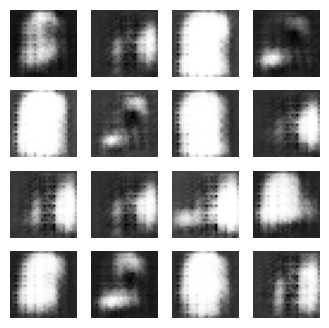

Epoch 10/30, Gen Loss: 0.7588, Disc Loss: 1.2957
Epoch 11/30, Gen Loss: 0.7765, Disc Loss: 1.2788
Epoch 12/30, Gen Loss: 0.7869, Disc Loss: 1.2716
Epoch 13/30, Gen Loss: 0.8431, Disc Loss: 1.2152
Epoch 14/30, Gen Loss: 0.8857, Disc Loss: 1.1581
Epoch 15/30, Gen Loss: 0.9088, Disc Loss: 1.1292
Epoch 16/30, Gen Loss: 0.9409, Disc Loss: 1.1278
Epoch 17/30, Gen Loss: 1.0080, Disc Loss: 1.0500
Epoch 18/30, Gen Loss: 1.0903, Disc Loss: 0.9818
Epoch 19/30, Gen Loss: 1.1061, Disc Loss: 0.9830


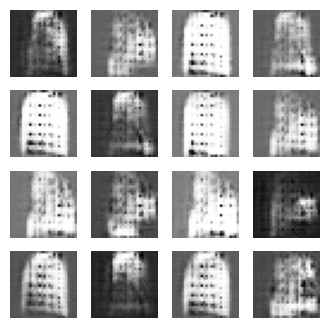

Epoch 20/30, Gen Loss: 1.1239, Disc Loss: 0.9712
Epoch 21/30, Gen Loss: 1.1885, Disc Loss: 0.9284
Epoch 22/30, Gen Loss: 1.1824, Disc Loss: 0.9361
Epoch 23/30, Gen Loss: 1.1491, Disc Loss: 0.9832
Epoch 24/30, Gen Loss: 1.1185, Disc Loss: 1.0179
Epoch 25/30, Gen Loss: 1.1113, Disc Loss: 1.0157
Epoch 26/30, Gen Loss: 1.1398, Disc Loss: 0.9943
Epoch 27/30, Gen Loss: 1.1358, Disc Loss: 1.0061
Epoch 28/30, Gen Loss: 1.1214, Disc Loss: 1.0184
Epoch 29/30, Gen Loss: 1.1396, Disc Loss: 1.0041


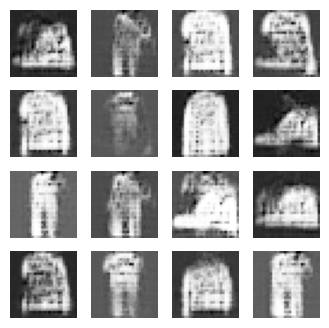

Epoch 30/30, Gen Loss: 1.1246, Disc Loss: 1.0282


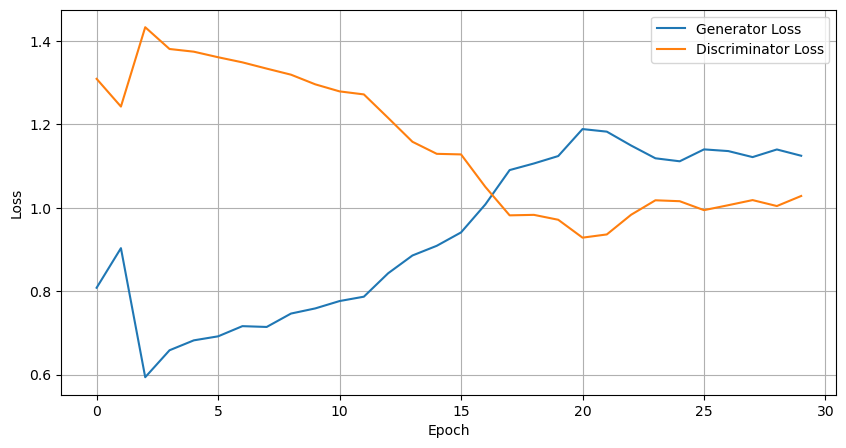

In [15]:
# Обучение модели
history = train(train_dataset, EPOCHS)
# Визуализация процесса обучения
plt.figure(figsize=(10, 5))
plt.plot([h[0] for h in history], label='Generator Loss')
plt.plot([h[1] for h in history], label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

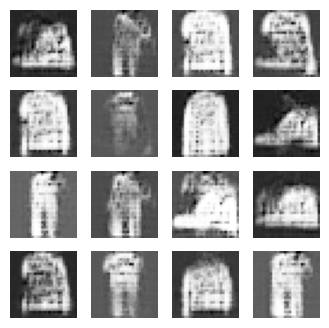

In [16]:
# Генерация финальных изображений
generate_and_save_images(generator, EPOCHS, seed)